In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sq

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
connection = sq.connect("./performance-measurements/af-test.db")
connection.row_factory = sq.Row

In [4]:
query = """
SELECT id, domain, protocol, responseStart, firstContentfulPaint, loadEventEnd 
FROM measurements 
WHERE (error = "" or error is null) AND firstContentfulPaint != 0
"""
df1 = pd.read_sql(query, connection, index_col="id")
df1.head()

,domain,protocol,responseStart,firstContentfulPaint,loadEventEnd
id,,,,,
b2e9f167-c79c-2bd7-32e2-a09a6eee9201,google.com,quic,1667.3,1870.6,4011.6
5f36ee73-2dc8-feda-13e6-9ab478b8936c,google.com,quic,1831.7,2016.3,4096.0
afaa6512-75cb-3eb4-cea8-58f75ecbdd49,youtube.com,quic,1344.6,2902.0,6407.6
222de864-0490-53d9-7078-977e3a3721de,youtube.com,quic,1356.0,2891.1,6300.8
0e60ff30-59a2-75ef-b0a1-51ba0af7e86b,facebook.com,quic,1680.5,2923.4,3740.6


In [5]:
query = """
SELECT measurement_id, MAX(elapsed), MIN(elapsed)
FROM lookups 
WHERE status = "NOERROR"
GROUP BY measurement_id
"""
df2 = pd.read_sql(query, connection, index_col="measurement_id")
df2.index.names = ['id']
df2.rename({'MAX(elapsed)': 'max_lookup_end', 'MIN(elapsed)': 'min_lookup_end'}, axis=1, inplace=True)
df2.head()

,max_lookup_end,min_lookup_end
id,,
018a6615-5b21-0967-3390-57a1a21f9f9c,298.733627,181.004023
0198cbe9-7015-d512-f413-003f86641216,187.322885,181.048917
026431c8-f1a7-7952-8f49-cadcffa9c404,563.401995,183.383684
035056d5-2b07-d3e5-2e59-9d7dcf87a405,311.723969,180.790404
03511035-d1b8-1967-6df4-497d77b7c244,186.849697,180.806039


In [6]:
df = pd.merge(df1, df2, 'inner', on='id')
df.head()

,domain,protocol,responseStart,firstContentfulPaint,loadEventEnd,max_lookup_end,min_lookup_end
id,,,,,,,
b2e9f167-c79c-2bd7-32e2-a09a6eee9201,google.com,quic,1667.3,1870.6,4011.6,188.390093,188.303492
5f36ee73-2dc8-feda-13e6-9ab478b8936c,google.com,quic,1831.7,2016.3,4096.0,390.664143,188.278612
afaa6512-75cb-3eb4-cea8-58f75ecbdd49,youtube.com,quic,1344.6,2902.0,6407.6,388.483376,188.286119
222de864-0490-53d9-7078-977e3a3721de,youtube.com,quic,1356.0,2891.1,6300.8,389.882310,188.281805
0e60ff30-59a2-75ef-b0a1-51ba0af7e86b,facebook.com,quic,1680.5,2923.4,3740.6,389.359148,188.378805


***pageload timeline***

**google.com**

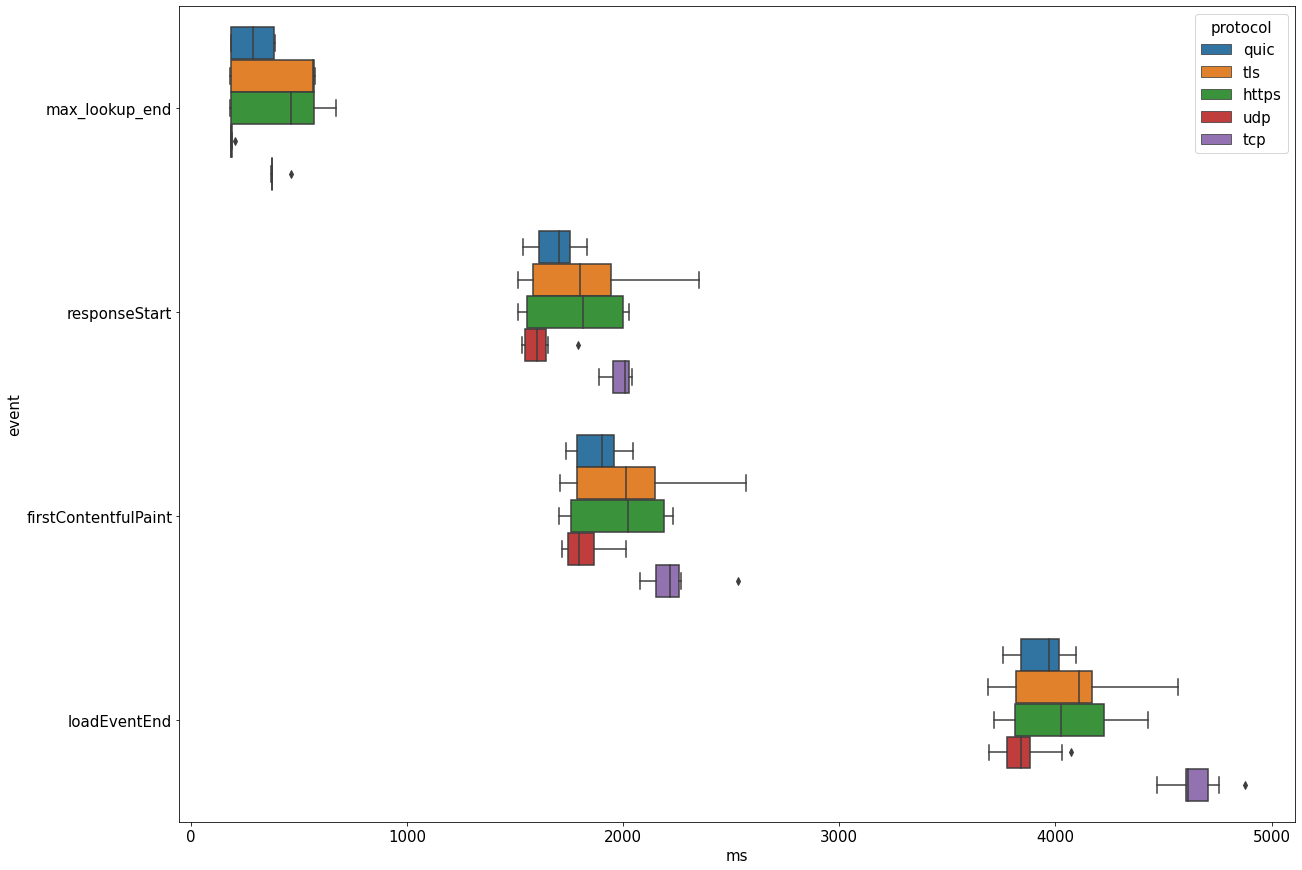

**youtube.com**

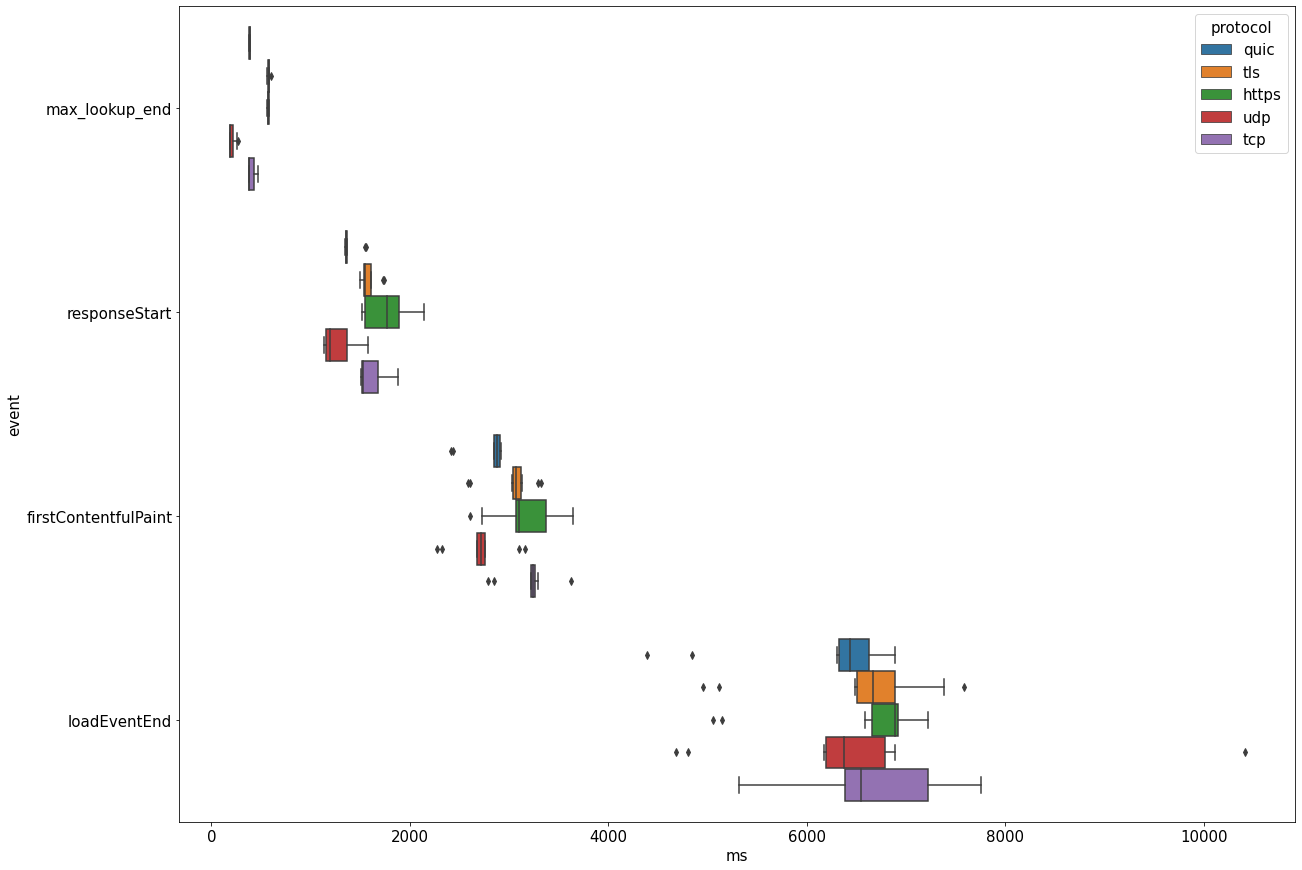

**facebook.com**

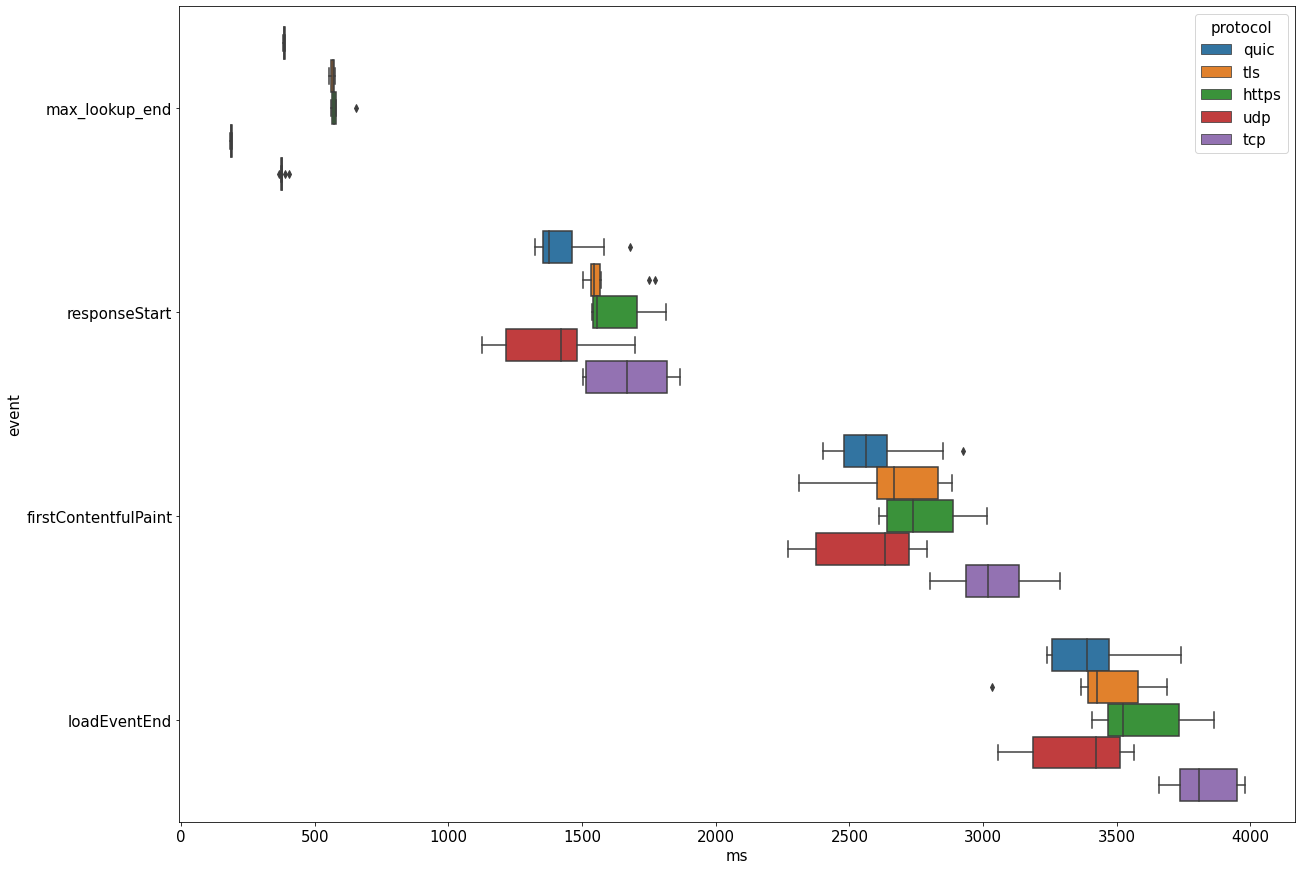

**netflix.com**

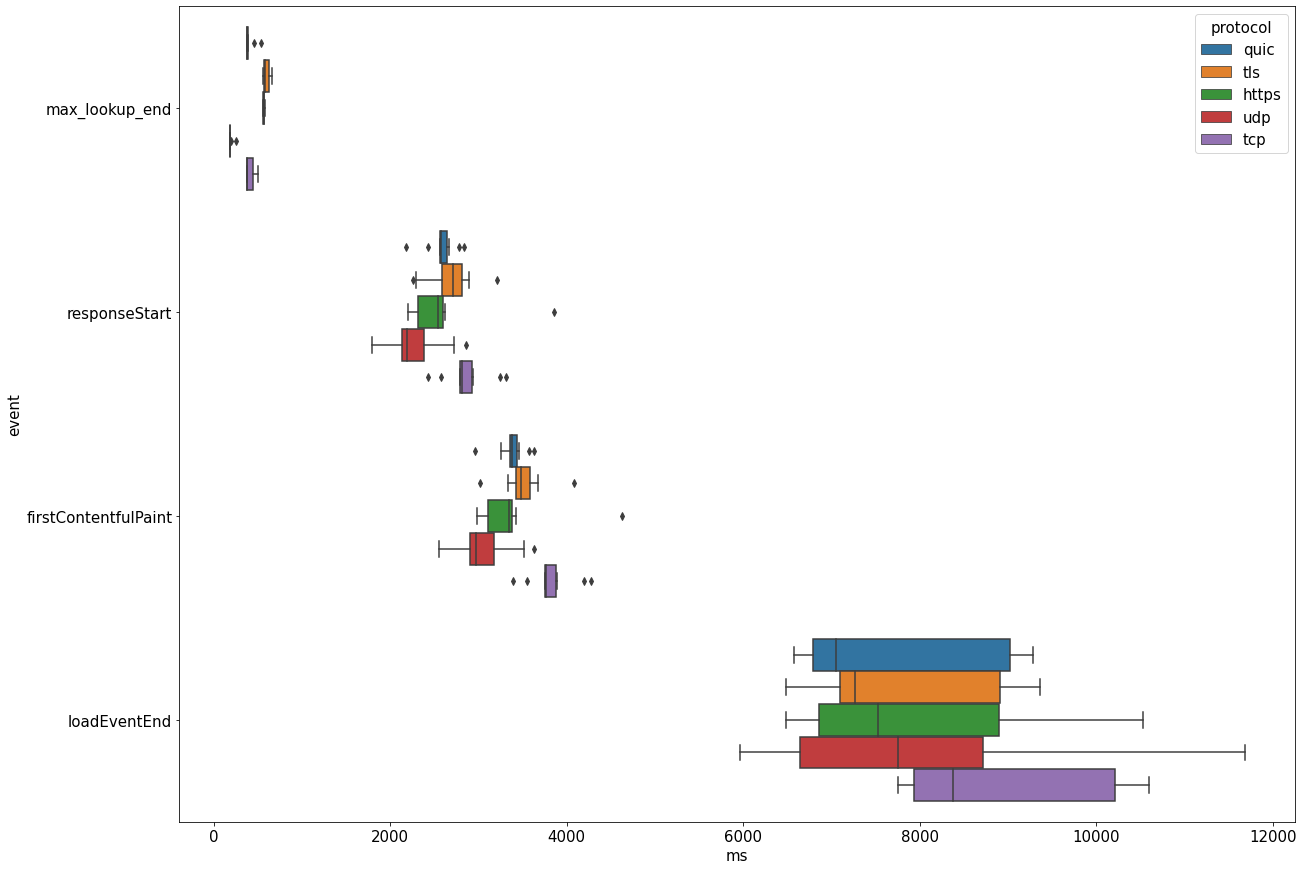

**twitter.com**

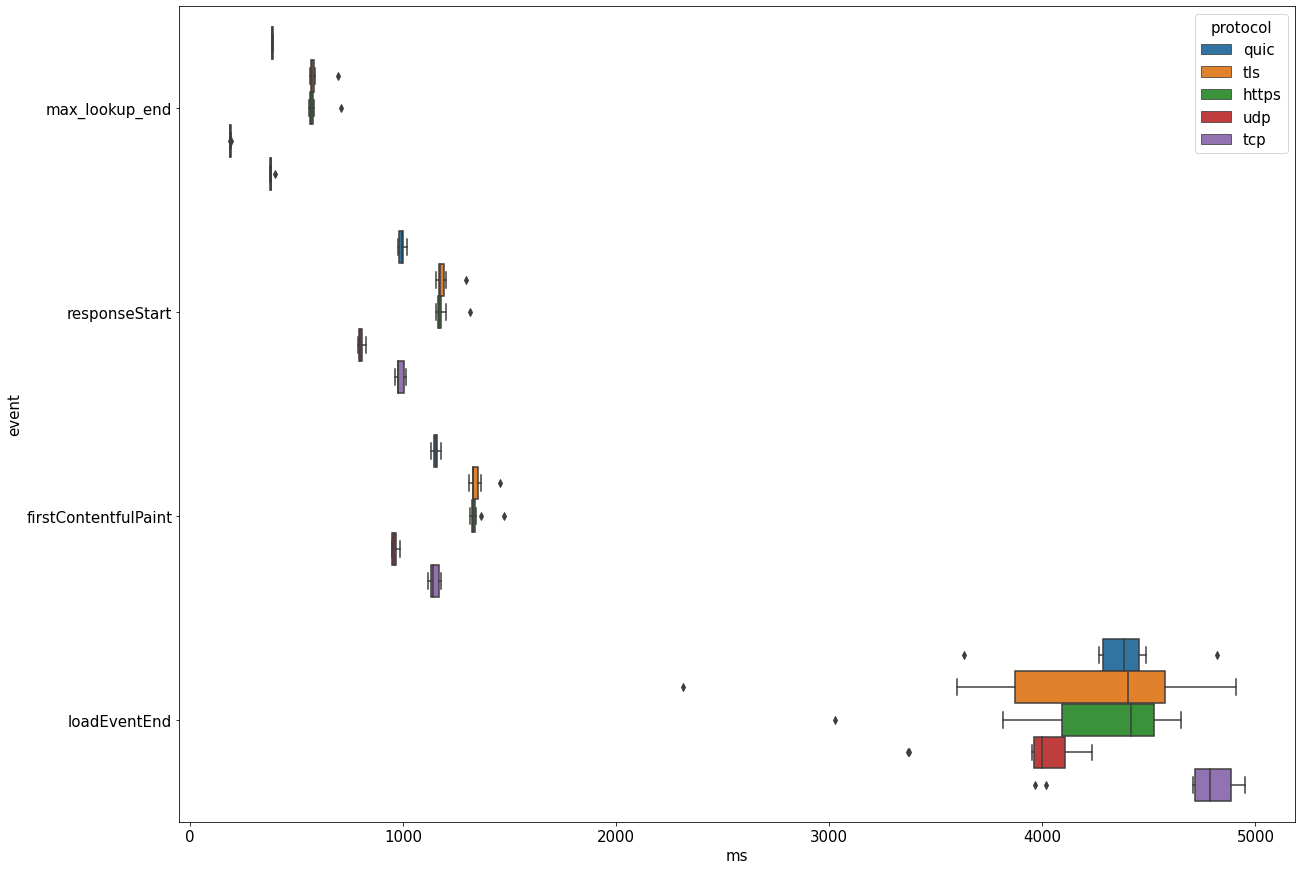

**instagram.com**

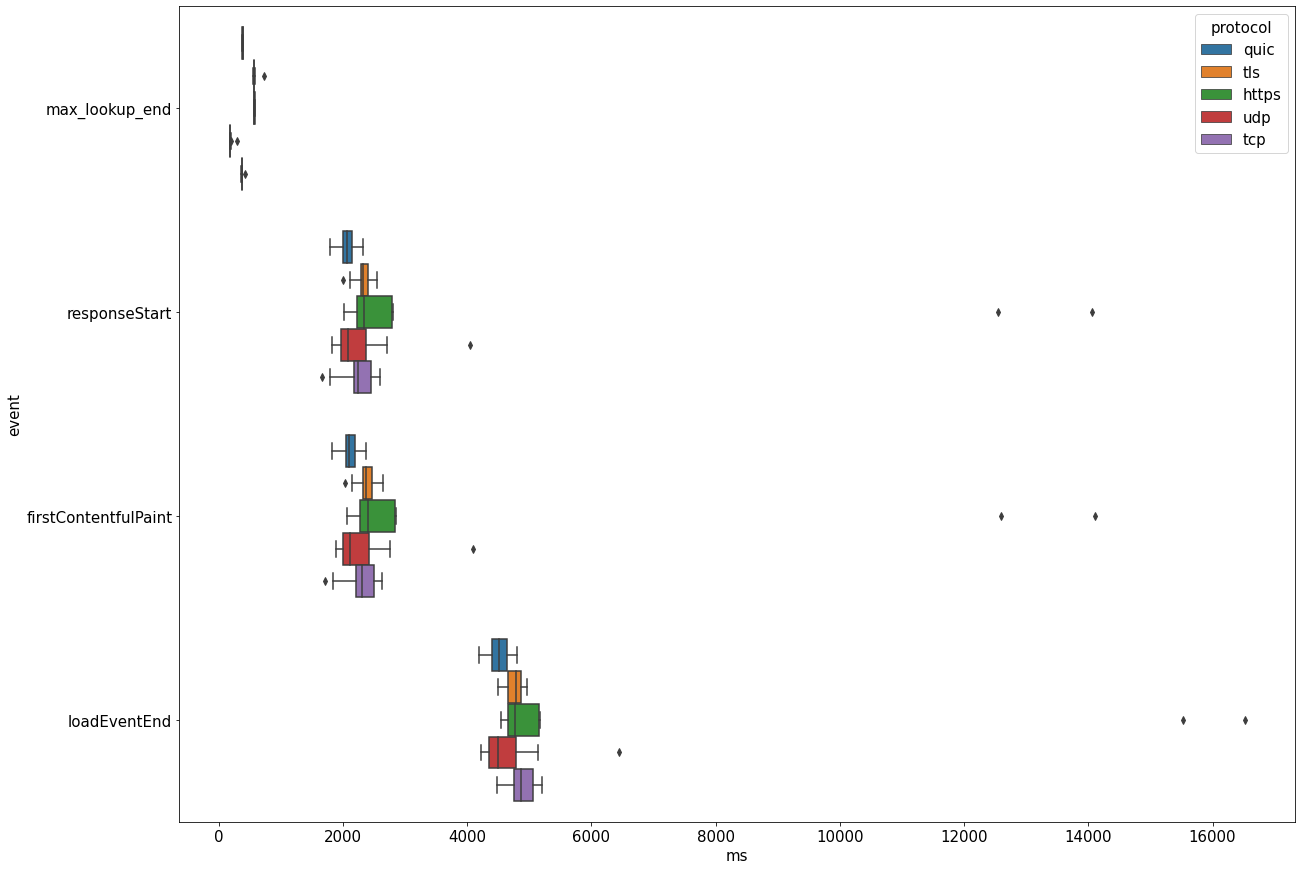

**tmall.com**

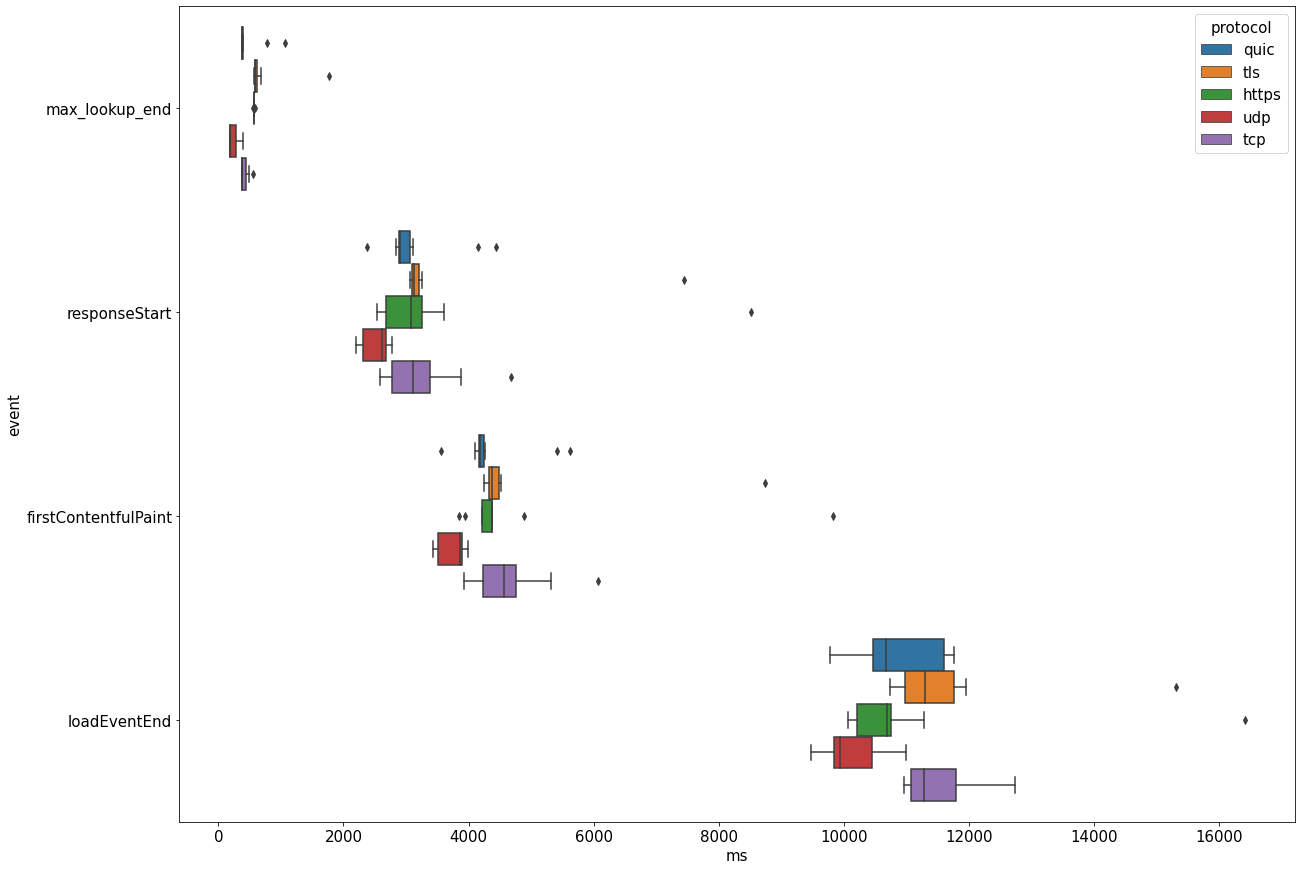

**linkedin.com**

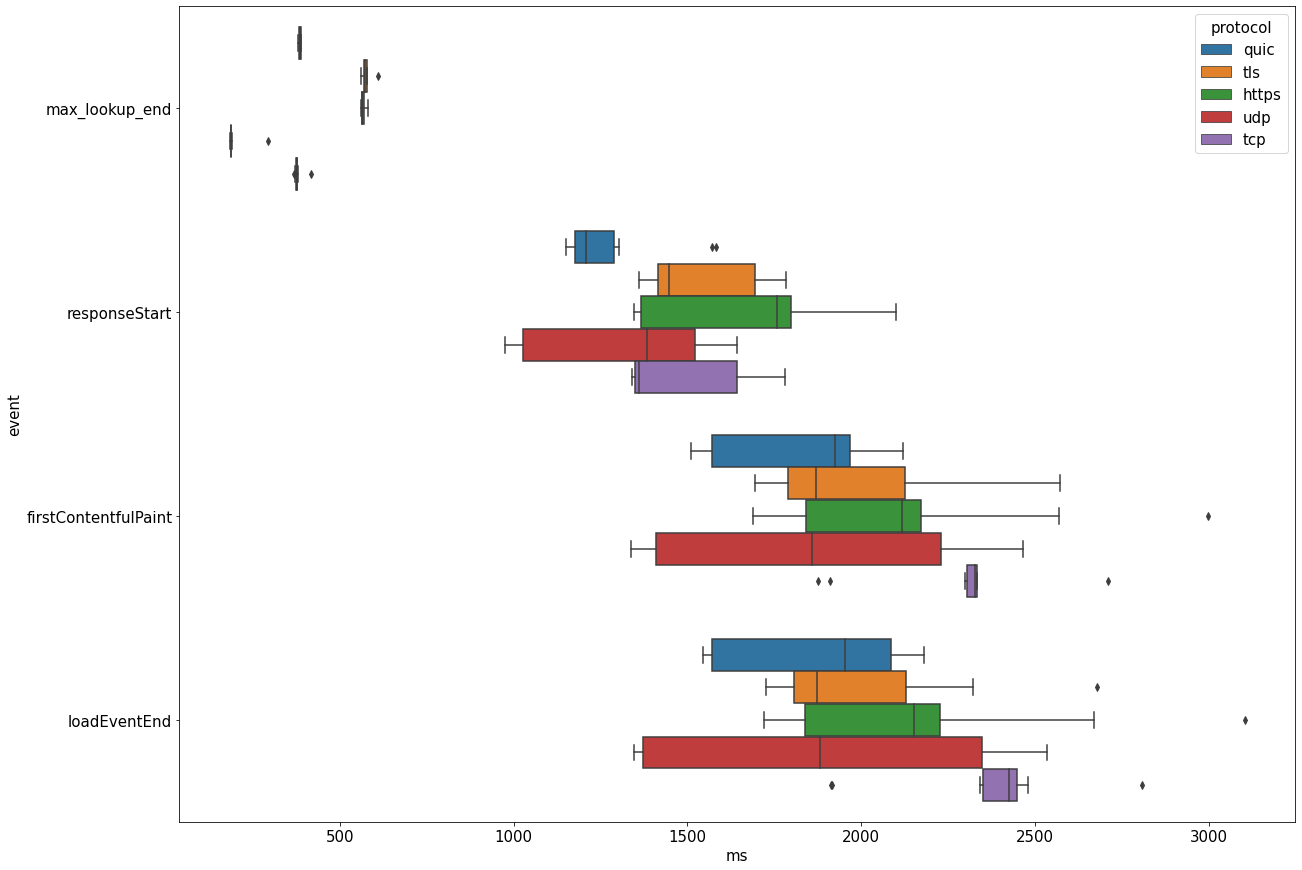

**wikipedia.org**

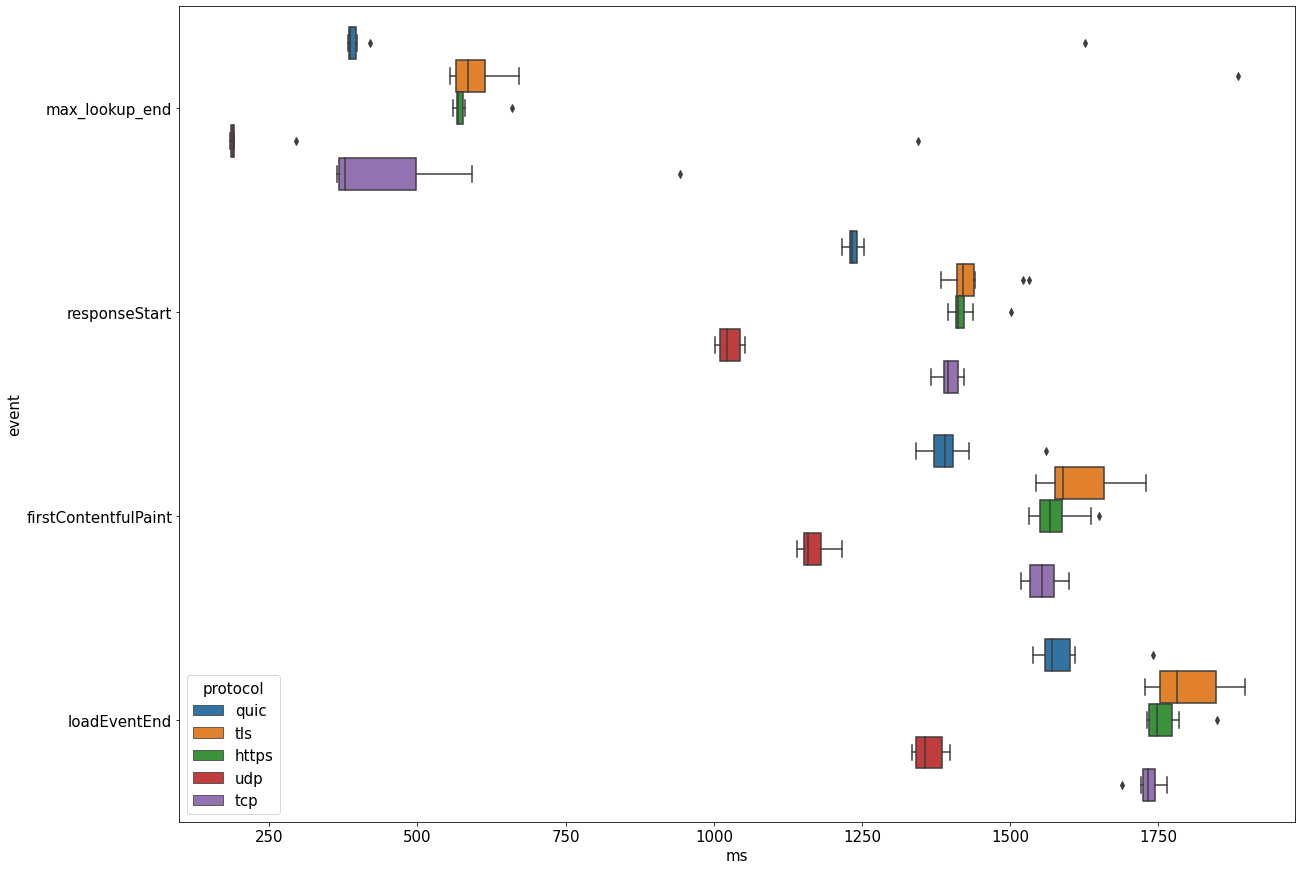

**baidu.com**

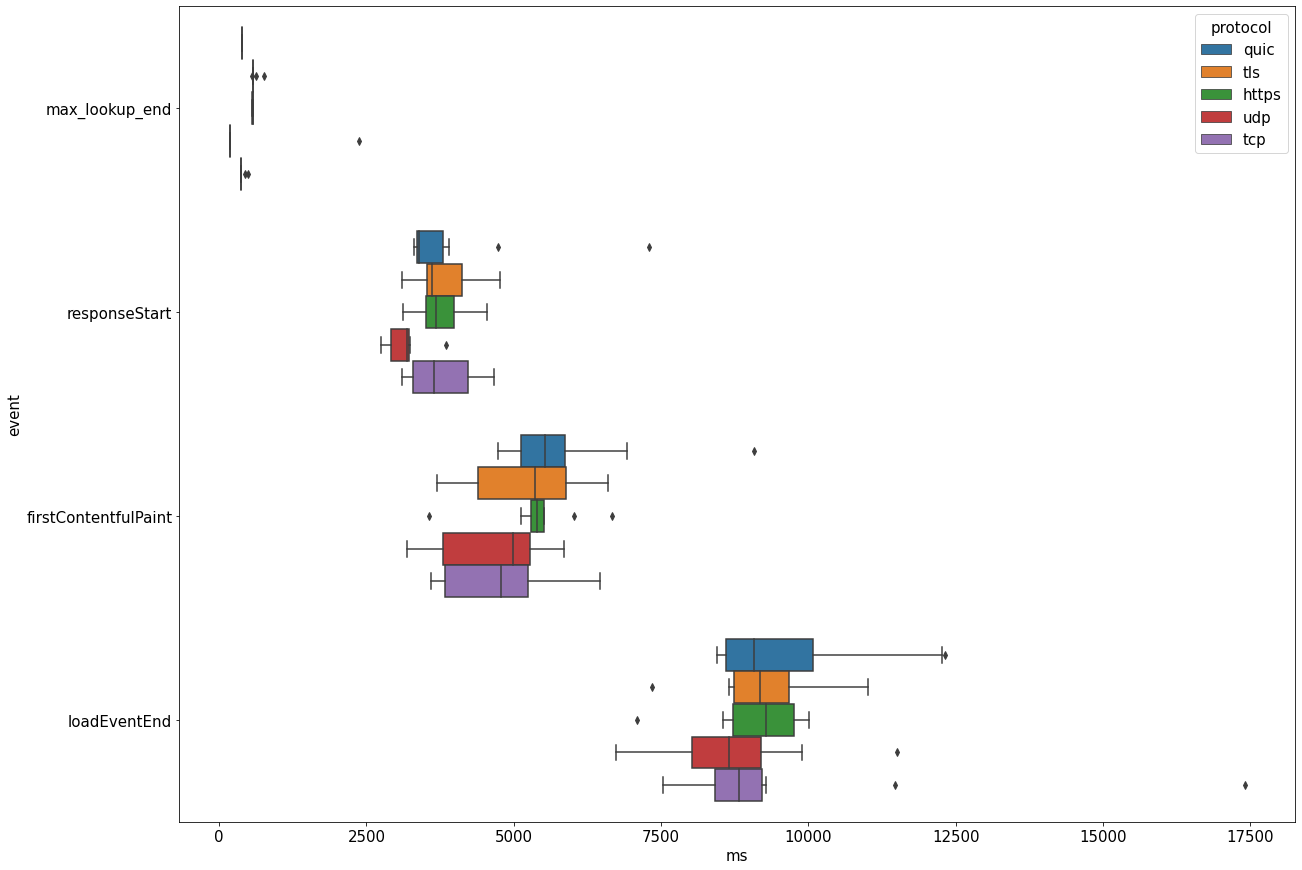

**microsoft.com**

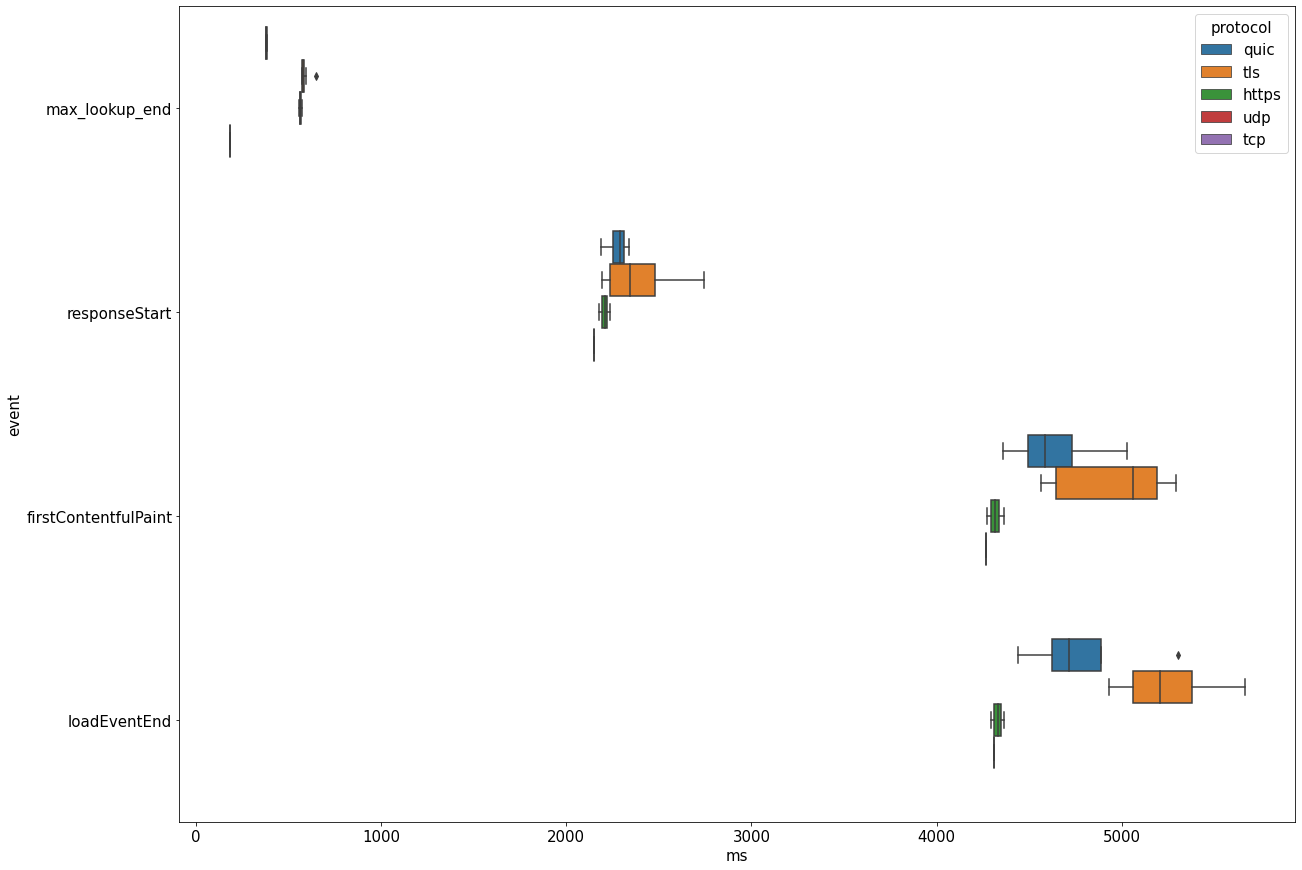

**apple.com**

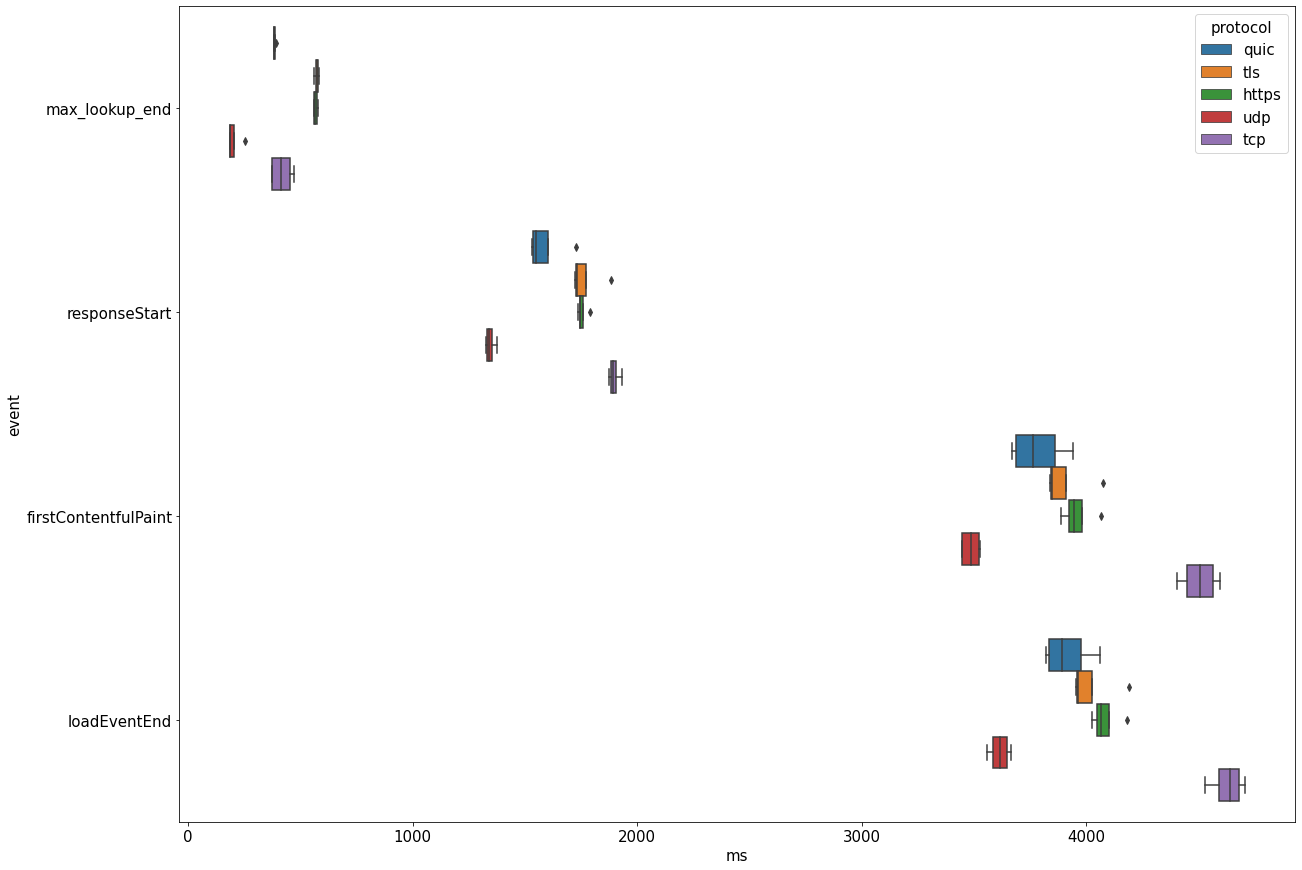

**qq.com**

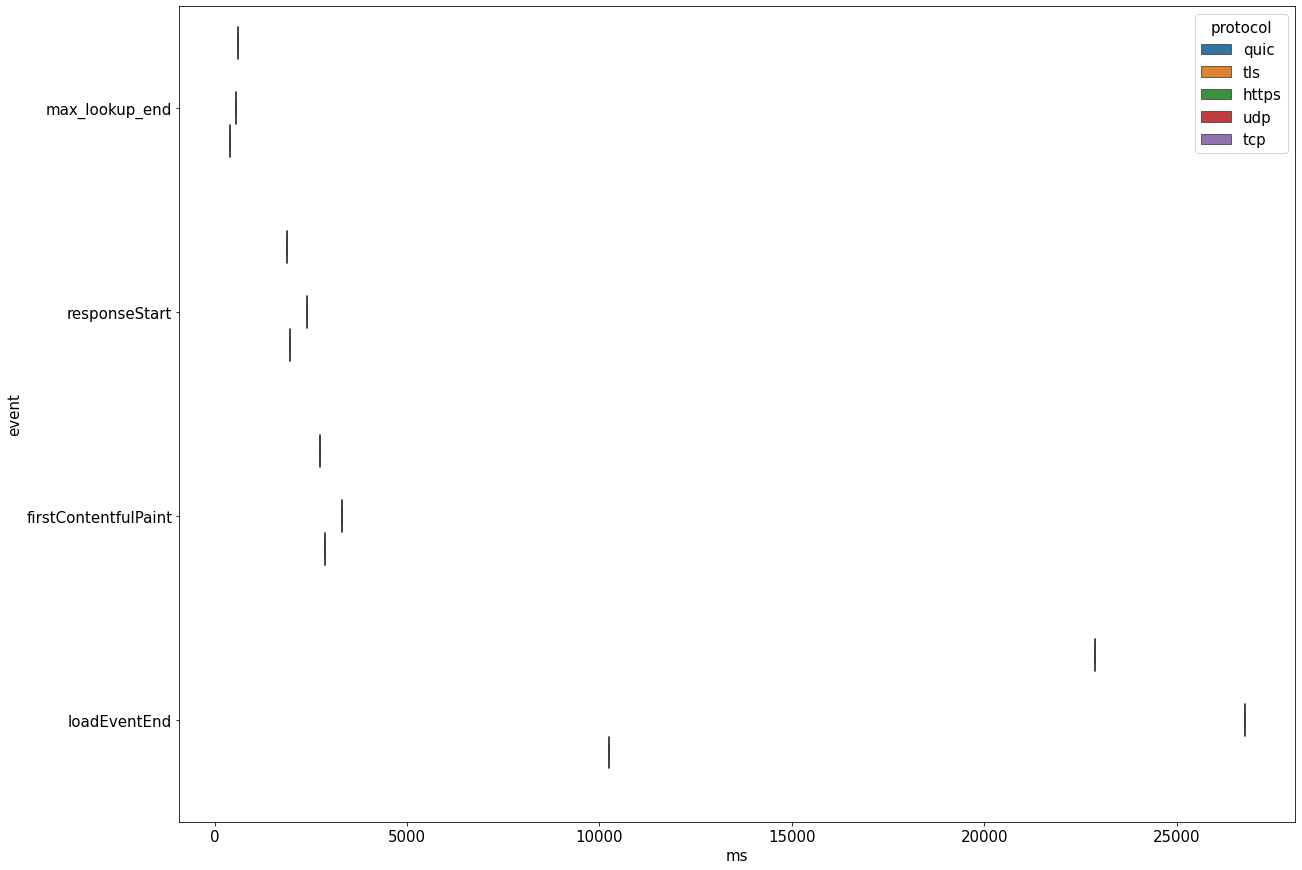

In [7]:
printmd(f"***pageload timeline***")

plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams["font.size"] = 15

protocols = ['quic', 'tls', 'https', 'udp', 'tcp']
for domain in df['domain'].unique():
    printmd(f"**{domain}**")
    df_domain = df[df['domain'] == domain]
    
    df_melted = pd.melt(df_domain, id_vars='protocol', value_vars=['max_lookup_end', 'responseStart', 'firstContentfulPaint', 'loadEventEnd'])
    ax = sns.boxplot(x='value', y='variable', hue='protocol', hue_order=protocols, data=df_melted, orient='h')
    ax.set_ylabel('event')
    ax.set_xlabel('ms')
    plt.show()

***MIN and MAX lookup times***

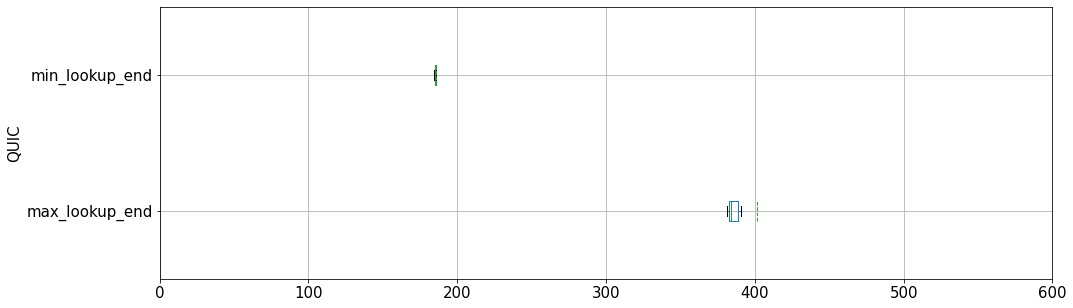

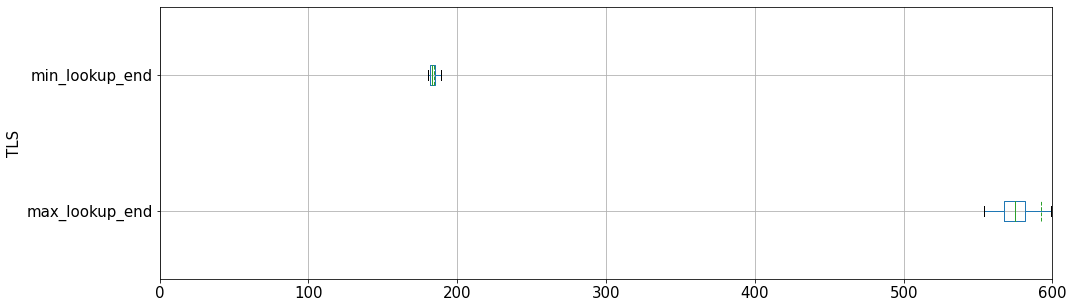

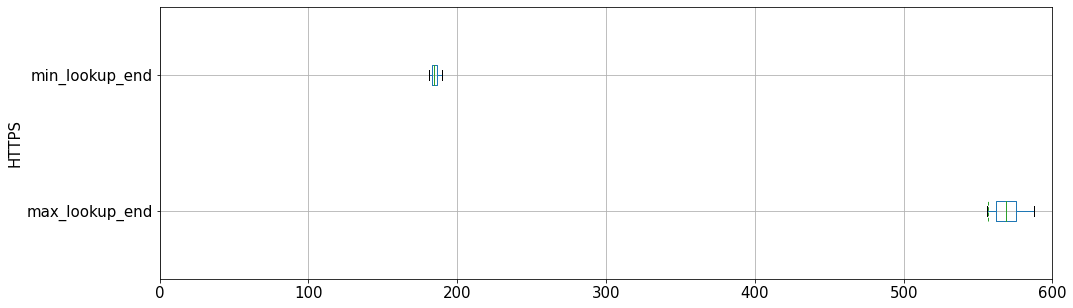

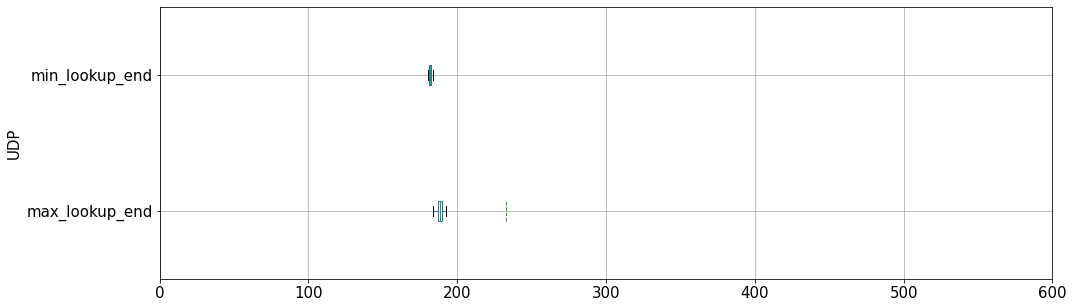

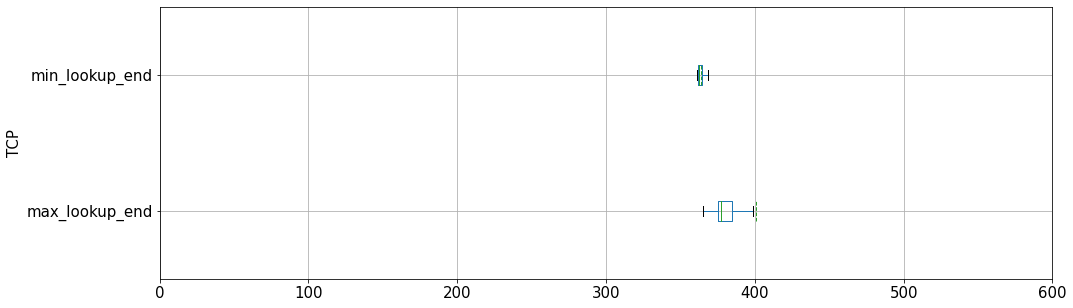

In [10]:
printmd(f"***MIN and MAX lookup times***")

plt.rcParams["figure.figsize"] = (16,5)
plt.rcParams["font.size"] = 15

protocols = ['quic', 'tls', 'https', 'udp', 'tcp']
for protocol in protocols:
    df_protocol = df[df['protocol'] == protocol]

    ax = df_protocol.boxplot(column=['max_lookup_end', 'min_lookup_end'], vert=False, sym = "", meanline = True, showmeans = True)
    ax.set_ylabel(protocol.upper())
    ax.set_xlim(0, 600)
    plt.show()